# Thai2fit Language Model Pre-training

The goal of this notebook is to train a language model using the [fast.ai](http://www.fast.ai/) version of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182), with data from [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2) last updated February 17, 2019. Using 40M/200k/200k tokens of train-validation-test split, we achieved validation perplexity of **51.6376 with 60,003 embeddings at 400 dimensions**, compared to state-of-the-art as of October 27, 2018 at **42.41 for English WikiText-2 by [Yang et al (2018)](https://arxiv.org/abs/1711.03953)**. To the best of our knowledge, there is no comparable research in Thai language at the point of writing (February 17, 2019).

Our workflow is as follows:

* Retrieve and process [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2) according to [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual)
* Perform 40M/200k/200k tokens of train-validation-test split split
* Minimal text cleaning and tokenization using `newmm` with frozen dictionary (`engine='ulmfit'`) of [pyThaiNLP](https://github.com/pyThaiNLP/pythainlp/)
* Train language model
* Evaluate model based on perplexity and eyeballing
* Extract embeddings to use as "word2vec"

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *    
from fastai.text import * 
from fastai.callbacks import CSVLogger

data_path = 'th-all-unk/'
model_path = 'thwiki_data/'

## Text Cleaning

We follow the dataset creation, pre- and post-processing of [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual):

* `ulmfit/create_wikitext.py` - Download thwiki in json format and separate them into 40M/200k/200k tokens of train-validation-test split. Articles with least than 100 tokens are removed. Also perform tokenization with whitespaces as separators.
* `ulmfit/postprocess_wikitext.py` - Replace numbers and replace out-of-vocabulary tokens with `xxunk` (frequency of less than 3).

We replaced the Moses Tokenizer with the following code to use [pyThaiNLP](https://github.com/pyThaiNLP/pythainlp/)'s `newmm` dictionary-based tokenizer with a frozen dictionary instead. We join the tokens within an article together to be tokenized later by the data bunch.

In [2]:
from pythainlp.tokenize import word_tokenize
class ThaiNLPTokenizer:
    def __init__(self,engine='ulmfit'):
        self.engine='ulmfit'
    def tokenize(self, t, return_str=True):
        res = word_tokenize(t,self.engine)
        return ' '.join(res) if return_str else res

Here is the statistics of the dataset:

```
before postprocessing
# documents: 121,027. # tokens: 39,378,410

after postprocessing
OOV ratio: 0.0042
data/wiki/th-all vocab size: 111,224
th.wiki.train.tokens. # of tokens: 41,482,435
th.wiki.valid.tokens. # of tokens: 200,563
th.wiki.test.tokens. # of tokens: 200,827
```

In [9]:
#snippet from https://github.com/n-waves/ulmfit-multilingual/blob/master/ulmfit/pretrain_lm.py
def istitle(line):
    return len(re.findall(r'^ ?= [^=]* = ?$', line)) != 0

def read_wiki_articles(filename):
    articles = []
    with open(filename, encoding='utf8') as f:
        lines = f.readlines()
    current_article = []
    for i,line in enumerate(lines):
        current_article.append(line)
        if i < len(lines)-2 and lines[i+1].strip() == "" and istitle(lines[i+2]):
            articles.append("".join(current_article))
            current_article = []
    articles.append("".join(current_article))
    print(f"Wiki text was split to {len(articles)} articles")
    return pd.DataFrame({'texts': np.array(articles, dtype=np.object)})

In [10]:
#last line is corrupted
train_df = read_wiki_articles(f'{data_path}th.wiki.train.tokens').iloc[:-1,:]
valid_df = read_wiki_articles(f'{data_path}th.wiki.valid.tokens').iloc[:-1,:]
test_df = read_wiki_articles(f'{data_path}th.wiki.test.tokens').iloc[:-1,:]
train_df.shape, valid_df.shape, test_df.shape

Wiki text was split to 53308 articles
Wiki text was split to 315 articles
Wiki text was split to 268 articles


((53307, 1), (314, 1), (267, 1))

In [14]:
#join tokens together
train_df['texts'] = train_df.texts.map(lambda x: ''.join(x.split()))
valid_df['texts'] = valid_df.texts.map(lambda x: ''.join(x.split()))
test_df['texts'] = test_df.texts.map(lambda x: ''.join(x.split()))

## Data Preparation

We used the `newmm` engine of `pyThaiNLP` to perform tokenization. Out of randomnum tokens from all of training set, we chose 60,000 embeddings (plus two for unknown and padding) of tokens which appeared more than twice (not typos) in the training set.


We perform the following text processing:

* Fix html tags to plain texts
* Lowercase all English words and if a word is written in all caps, we put it in a lower case and add `xxup` before
* Repetitive characters: Thai usually emphasizes adjectives by repeating the last character such as `อร่อยมากกกกกกก` to `อร่อยมาก xxrep 7 ` so that the word still retains its original form. 
* Normalize character order: for instance `นำ้` to `น้ำ`
* Add spaces around / and #
* Remove multiple spaces and newlines
* Remove empty brackets of all types (`([{`) which might result from cleaning up
* `pyThaiNLP`'s `newmm` word tokenizer with frozen dictionary (`engine ='ulmfit'`)  is used to tokenize the texts.

### Thai Tokenizer

We use the `newmm` tokenizer with a dictionary frozen as of 2018-10-23.

In [16]:
text='วิทยาศาสตร์ดาวเคราะห์เป็นสาขาวิชาที่ศึกษาเกี่ยวกับองค์ประกอบของดาวเคราะห์'
a = word_tokenize(text,engine='ulmfit')
a

['วิทยาศาสตร์',
 'ดาวเคราะห์',
 'เป็น',
 'สาขาวิชา',
 'ที่',
 'ศึกษา',
 'เกี่ยวกับ',
 'องค์ประกอบ',
 'ของ',
 'ดาวเคราะห์']

In [40]:
#integrated into pythainlp.ulmfit.utils
from fastai.text.transform import *
from pythainlp.tokenize import word_tokenize
from pythainlp.util import normalize as normalize_char_order

class ThaiTokenizer(BaseTokenizer):
    "Wrapper around a newmm tokenizer to make it a `BaseTokenizer`."
    def __init__(self, lang = 'th'):
        self.lang = lang
    def tokenizer(self, t):
        return(word_tokenize(t,engine='ulmfit'))
    def add_special_cases(self, toks):
        pass
    
def replace_rep_after(t):
    "Replace repetitions at the character level in `t` after the repetition"
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c} {TK_REP} {len(cc)+1} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)

def rm_useless_newlines(t):
    "Remove multiple newlines in `t`."
    return re.sub('[\n]{2,}', ' ', t)

def rm_brackets(t):
    "Remove all empty brackets from `t`."
    new_line = re.sub('\(\)','',t)
    new_line = re.sub('\{\}','',new_line)
    new_line = re.sub('\[\]','',new_line)
    return(new_line)

#in case we want to add more specific rules for thai
pre_rules_th = [fix_html, replace_rep_after, normalize_char_order, 
                spec_add_spaces, rm_useless_spaces, rm_useless_newlines, rm_brackets]
post_rules_th = [replace_all_caps, deal_caps]

### Data Bunch

We trained the language model based on 40M/200k/200k tokens of train-validation-test split from [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2). Tokens are generated and numericalized filtering all words with frequency more than 3 and at maximum vocab size of 60,000 (plus unknown and padding tokens).

In [41]:
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

In [23]:
# data = (ItemLists(model_path, 
#     TextList.from_df(train_df, model_path, cols=['texts'], processor=processor),
#     TextList.from_df(valid_df, model_path, cols=['texts'], processor=processor))
#     .label_for_lm()
#     .add_test(TextList.from_df(test_df, model_path, cols=['texts'], processor=processor))
#     .databunch(bs=64))
# data.sanity_check()
# data.save('thwiki_lm_data.pkl')

In [10]:
data = load_data(model_path,'thwiki_lm_data.pkl')
data.sanity_check()
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(53307, 314, 267)

In [28]:
data.show_batch(5)

idx,text
0,คือ พ.ศ. 2412 ) เป็น พระราชธิดา พระองค์ สุดท้าย ใน พระ บาท สมเด็จ พระ จอมเกล้า เจ้า อยู่ หัว ประสูติ แต่ จ้า จอมมารดา ห่วง ธิดา ขุน เทพ ฯ กับ เก ษ มี พระ เชษฐ ภคินี พระ เชษฐา ร่วม เจ้าจอมมารดา เดียวกัน 2 พระองค์ คือ พระเจ้า บรมวงศ์ เธอ พระองค์ เจ้า บุษบัน บัว ผัน และ พระเจ้า บรมวงศ์ เธอ พระองค์ เจ้า ไช ยัน ตม งคล กรมหมื่น มหิศร ราช หฤทัย พระองค์ ประสูติ หลัง สมเด็จ พระ บรม ชนก
1,"มานัต = ลัก ซอ ร์= ลัก ซอ ร์ ลัก ซอ ร์(;) เป็น นคร ในประเทศ อียิปต์ เป็น เมืองหลวง ของ เขต ผู้ว่า การลัก ซอ ร์ มี ประชากร 487 @,@ 896 คน ( ค.ศ. 2010 ) เมือง มี พื้นที่ ราว 416 ตร. กม. ( 161 ตร. ไมล์ ) เป็น สถาน ที่ตั้ง ของ เมือง อียิปต์ โบราณ เมือง ที บส์ อาจ กล่าว ได้ ว่า เป็น "" พิพิธภัณฑ์ เปิด โล่ง ที่ ใหญ่ ที่สุด ของ โลก """
2,จาก การ ทำความเข้าใจ ธรรมชาติ ของ xxunk ใน เชิง เคมี ทำให้ แพทย์ สามารถ ค้นพบ วิธี การรักษา โรคติดต่อ ได้การ สนับสนุน ทางการแพทย์ . แพ รา เซ ลซัส เป็น ผู้ริเริ่ม การ ใช้ แร่ธาตุ และ สารเคมี ใน ทางการแพทย์ ใน ทาง ลึกลับ เขา มองว่า โรคภัยไข้เจ็บ และ สุขภาพ นั้น ขึ้นอยู่กับ ความ ลงตัว ของ มนุษย์ และ ธรรมชาติ เขา ใช้ วิธี ที่ แตกต่าง ไป จาก คนอื่น ก่อนหน้านี้ การ ใช้การ เปรียบเทียบ นี้ ไม่ได้ อยู่ ใน ลักษณะ ของ จิตวิญญาณ บริสุทธิ์ แต่
3,"ส์ 3 แอม บิ ชัน ส์= เดอะ ซิม ส์ 3 แอม บิ ชัน ส์ เดอะ ซิม ส์ 3 แอม บิ ชัน ส์ เป็น ภาค เสริม ตัว ที่ 2 ของ เกม เดอะ ซิม ส์ 3 สำหรับ ประเทศไทย มี การ วาง จำหน่าย ใน วันที่ 1 มิถุนายน พ.ศ. 2553 ""' เดอะ ซิม ส์ 3 แอม บิ ชัน ส์"" มา พร้อมกับ โหมด ใหม่ ซึ่ง ผู้ เล่น สามารถ เข้า ไปดู และ ควบคุม การทำงาน ของ ชาว"
4,"อื่น . อักษร แบบ อื่น ของ อิ คือ คะ นะ ขนาดเล็ก xxunkxxunk ใช้ สำหรับ แสดง เสียง ภาษาต่างประเทศ ของ ญี่ปุ่น เช่น xxunk ( วิ ), xxunk (ค วิ ), xxunk ( ซิ ), xxunkxxunkxxunk ( ดิ ), xxunkxxunk หรือ ใช้ สำหรับ ลากเสียง สระ อิ ให้ ยาว ขึ้น เป็น อี ภาษา ไอ นุ ใช้ คะ ตะ กะ นะ ขนาดเล็ก xxunk เป็น พยัญชนะ สะกด เหมือน การ สะกด ด้วย - ย และ อ่าน ออกเสียง"


In [25]:
next(iter(data.test_dl))

[tensor([[    2,    42,    36,  ..., 13392,    57,    31],
         [   24,   627,    30,  ...,   312,   565,    13],
         [   11,   266,    25,  ...,  3390,    10,    21],
         ...,
         [ 3166, 14325,    34,  ...,  2759,    12,  2057],
         [  519,    20,     9,  ...,   115, 10305,    10],
         [ 7289,   187,   321,  ...,    16, 10132, 10132]], device='cuda:0'),
 tensor([[   42,    36,  5499,  ...,    57,    31,    56],
         [  627,    30,   160,  ...,   565,    13,  6010],
         [  266,    25,  1380,  ...,    10,    21,  3993],
         ...,
         [14325,    34, 25768,  ...,    12,  2057, 12467],
         [   20,     9,   316,  ..., 10305,    10,    48],
         [  187,   321,    78,  ..., 10132, 10132, 30111]], device='cuda:0')]

In [31]:
# pickle.dump(data.vocab.itos, open(f'{model_path}models/thwiki_itos.pkl','wb'))

### Vocab

In [32]:
vocab_lm = data.vocab
vocab_lm.numericalize(word_tokenize('สวัสดีครับพี่น้อง', engine='ulmfit'))

[10616, 7258, 1339]

In [33]:
vocab_lm.textify([10616, 7258, 1339])

'สวัสดี ครับ พี่น้อง'

## Language Modeling

We train the language model according to the [ULMFit paper](https://arxiv.org/abs/1801.06146). We use the name hyperparameters as [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual).

In [34]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn.callback_fns += [partial(CSVLogger, filename=f"{model_path}/logs")]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03


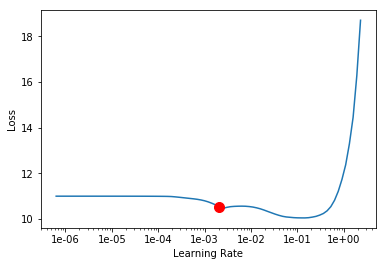

In [35]:
learn.lr_find()
learn.recorder.plot()

In [50]:
# learn.freeze_to(-1)
# learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

| epoch | train_loss | valid_loss | accuracy |
|-------|------------|------------|----------|
| 1     | 5.689881   | 5.479321   | 0.176962 |
| 2     | 5.14165    | 4.914922   | 0.223256 |
| 3     | 4.945699   | 4.661891   | 0.242748 |
| 4     | 4.708307   | 4.471861   | 0.261348 |
| 5     | 4.636846   | 4.337728   | 0.273785 |
| 6     | 4.487616   | 4.237517   | 0.285252 |
| 7     | 4.370384   | 4.161622   | 0.293807 |
| 8     | 4.291326   | 4.100852   | 0.30109  |
| 9     | 4.267814   | 4.071167   | 0.303888 |
| 10    | 4.217663   | 4.065733   | 0.304822 |

In [51]:
# learn.unfreeze()
# learn.fit_one_cycle(10, 1e-3/3, moms=(0.8, 0.7))

| epoch | train_loss | valid_loss | accuracy |
|-------|------------|------------|----------|
| 1     | 4.179729   | 4.052608   | 0.304963 |
| 2     | 4.16306    | 4.047963   | 0.305331 |
| 3     | 4.184966   | 4.044866   | 0.305482 |
| 4     | 4.218517   | 4.023499   | 0.307901 |
| 5     | 4.183966   | 4.001536   | 0.310346 |
| 6     | 4.165901   | 3.985509   | 0.312516 |
| 7     | 4.091527   | 3.966779   | 0.315573 |
| 8     | 4.078772   | 3.952682   | 0.317021 |
| 9     | 4.020618   | 3.944576   | 0.318096 |
| 10    | 4.043382   | 3.94425    | 0.317961 |

In [ ]:
# learn.save('thwiki_lm')
# learn.save_encoder('thwiki_enc')

### Eyeballing Test
We perform eyeballing test by having the model "fill in the blanks".

In [3]:
from utils import *
from fastai import *    
from fastai.text import * 
from fastai.callbacks import CSVLogger
data_path = 'th-all-unk/'
model_path = 'thwiki_data/'

#data
data = load_data(model_path,'thwiki_lm_data.pkl')
data.sanity_check()

#lm
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

#load weights
learn.load('thwiki_lm');

In [24]:
learn.predict('สวัสดีครับ พี่น้องเสื้อ',100, sep='', temperature = 0.5)

'สวัสดีครับ พี่น้องเสื้อแดง=รองเท้าแดงเสื้อแดง(อังกฤษ:St.โก้)เป็นภาพยนตร์ไทยแนวตลก-แฟนตาซีออกฉายในปีพ.ศ.2544กำกับโดยยุทธนามุกดาสนิทนำแสดงโดยสันติสุขพรหมศิริ,สุวนันท์คงยิ่ง,สุรชัยจันทิมาธร,บุญชูสกุลเจริญสุข,สุกัญญาวงศ์สวัสดิ์,สุกัญญาไชยศิริ,วิยะดาอุมารินทร์,นิรุตติ์ศิริจรรยา,อุบลรัตน์ปิยะศิริ,สุรชัยจันทิมาธร,รัช'

## Embeddings

We extract the embedding layer of the encoder to be used in the same manner as `word2vec`. We can also create sentence vector by summing or averaging the vectors. For more details about `word2vec` use cases, see`word2vec_examples.ipynb`. Note that we use word vectors from `v0.1` since it was trained specifically for the purpose and has comparable dimensions to `fastText` embeddings.

### Extract

In [8]:
#how we extracted the embeddings
emb_weights = list(learn.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)
emb_np.shape

(60003, 400)

In [33]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(f'{model_path}models/thai2vec.vec',binary=False,
                                         unicode_errors = 'ignore')

In [35]:
model.save_word2vec_format(f'{model_path}models/thai2vec.vec',f'{model_path}models/thai2vec.vocab',False)
model.save_word2vec_format(f'{model_path}models/thai2vec.bin',None,True)

## Document Vectors

We can also get document vector from the language model by applying the encoder to a sentence.

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tt = ThaiTokenizer()
def document_vector(ss, learn, data):
    s = tt.tokenizer(ss)
    t = torch.tensor(data.vocab.numericalize(s), requires_grad=False).to(device)
    m = learn.model[0].encoder.to(device)
    res = m(t).mean(0).cpu().detach().numpy()
    return(res)

In [93]:
ss = 'วันนี้วันดีปีใหม่'
document_vector(ss,learn,data)

array([ 0.066298,  0.307813,  0.246051,  0.008683, ..., -0.058363,  0.133258, -0.289954, -1.770246], dtype=float32)

In [4]:
from pythainlp.ulmfit import *
document_vector('วันนี้วันดีปีใหม่',learn,data)

array([ 0.066298,  0.307813,  0.246051,  0.008683, ..., -0.058363,  0.133258, -0.289954, -1.770246], dtype=float32)